In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed
%env CUDA_VISIBLE_DEVICES

env: CUDA_VISIBLE_DEVICES=MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed


'MIG-4f53211e-ceab-5aa7-b0ba-6ef87e62c8ed'

In [2]:
# import argparse
import json
import re
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from monai.losses import DiceCELoss
from monai.networks.nets import VNet

# import torchvision
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

import cfg
from dataset_mevis import MRI_dataset_batched
from dsc import dice_coeff
from funcs import *
from models.sam import sam_model_registry, build_sam_mevis
from models.sam.modeling.prompt_encoder import attention_fusion
from predict_funs import *
from utils import eval_seg, generate_click_prompt, iou_torch, pixel_accuracy

# %matplotlib inline

In [3]:
print(torch.cuda.mem_get_info())
print(torch.cuda.memory_allocated())

(20773273600, 20937965568)
0


In [4]:
SEED = 2003
IMGS_PATH = Path("/data/sab_data/images")
MASKS_PATH = Path("/data/sab_data/masks")
TRAIN_DATA_FILE = "Train_data_files_resampled.json"
TEST_DATA_FILE ="Test_data_files_resampled.json"
DEVICE = torch.device("cuda:" + str(args.gpu_device))
CHECKPOINT_DIRECTORY = Path("/data/sab_data/checkpoints")
LOGDIR = Path("/data/sab_data/model_logs")
sam_checkpoint = "decoder_only/resampled/2024-08-12 10:30:07/mevis_sam-epoch60.pth"
# sam_checkpoint = "bone_sam.pth"

In [5]:
args = cfg.parse_args()
args.thd = True
args.if_mask_decoder_adapter = True
args.if_encoder_adapter = True
args.decoder_adapt_depth = 2
args.prompt_probability = 0.3


In [6]:
# V2
def new_forward(
    self,
    batched_input: dict,
    multimask_output: bool = True,
    if_attention=False,
) -> dict[str, torch.Tensor]:
    """
    Predicts masks end-to-end from provided images and prompts.
    If prompts are not known in advance, using SamPredictor is
    recommended over calling the model directly.

    Arguments:
        batched_input (list(dict)): A list over input images, each a
        dictionary with the following keys. A prompt key can be
        excluded if it is not present.
            'image': The image as a torch tensor in 3xHxW format,
            already transformed for input to the model.
            'point_coords': (torch.Tensor) Batched point prompts for
            this image, with shape BxNx2. Already transformed to the
            input frame of the model.
            'point_labels': (torch.Tensor) Batched labels for point prompts,
            with shape BxN.
            'boxes': (torch.Tensor) Batched box inputs, with shape Bx4.
            Already transformed to the input frame of the model.
            'mask_inputs': (torch.Tensor) Batched mask inputs to the model,
            in the form Bx1xHxW.
        multimask_output (bool): Whether the model should predict multiple
        disambiguating masks, or return a single mask.

    Returns:
        (list(dict)): A list over input images, where each element is
        as dictionary with the following keys.
            'masks': (torch.Tensor) Batched binary mask predictions,
            with shape BxCxHxW, where B is the number of input prompts,
            C is determined by multimask_output, and (H, W) is the
            original size of the image.
    """
    image_embeddings = self.image_encoder(batched_input["image"])
    if if_attention:
        image_embeddings = self.attention_fusion(
            image_embeddings, batched_input["atten_maps"].unsqueeze(1)
        )

    if "point_coords" in list(batched_input.keys()):
        points = (batched_input["point_coords"], batched_input["point_labels"])
    else:
        points = None

    sparse_embeddings, dense_embeddings = self.prompt_encoder(
        points=points,
        boxes=batched_input.get("boxes", None),
        masks=batched_input.get("mask_inputs", None),
    )
    pe = torch.stack(
        [self.prompt_encoder.get_dense_pe() for _ in range(image_embeddings.shape[0])],
        dim=0,
    ).squeeze(1)
    low_res_masks, iou_predictions = self.mask_decoder(
        image_embeddings=image_embeddings,
        image_pe=pe,
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=multimask_output,
    )

    return low_res_masks


sam_mevis = build_sam_mevis(
    args,
    checkpoint=CHECKPOINT_DIRECTORY / "mobile_sam.pt",
    mevis_checkpoint=CHECKPOINT_DIRECTORY / sam_checkpoint,
    num_classes=2,
    device=DEVICE,
)

sam_mevis.forward = new_forward.__get__(sam_mevis)

/home/ubuntu/Thesis_code/models/sam/build_sam.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/home/ubuntu/Thesis_code/models/sam/build_sam.

In [27]:
sam_mevis = sam_model_registry["vit_t"](
    args, checkpoint=CHECKPOINT_DIRECTORY / "mobile_sam.pt", num_classes=2
)
sam_mevis.attention_fusion = attention_fusion()
sam_mevis.load_state_dict(
    torch.load(
        CHECKPOINT_DIRECTORY / sam_checkpoint,
        map_location=torch.device(DEVICE),
    ),
    strict=True,
)
sam_mevis = sam_mevis.to("cpu")#DEVICE)

# vnet = VNet().to(DEVICE)
# vnet.load_state_dict(
#     torch.load(
#         CHECKPOINT_DIRECTORY / "atten.pth",
#         map_location=torch.device(DEVICE),
#     )
# )


/home/ubuntu/Thesis_code/models/sam/build_sam.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/tmp/ipykernel_81661/1057709973.py:6: FutureWa

In [8]:
for param in sam_mevis.parameters():
    param.requires_grad = True
pytorch_total_params = sum(p.numel() for p in sam_mevis.parameters() if p.requires_grad)
print(pytorch_total_params)

11492716


In [15]:
open_mask_decoder = [
    "transformer.layers.0.MLP_Adapter" +
    "transformer.layers.0.Adapter" +
    "transformer.layers.1.MLP_Adapter" +
    "transformer.layers.1.Adapter"
]
sam_mevis.eval()

for param in sam_mevis.parameters():
    param.requires_grad = False
pytorch_total_params = sum(p.numel() for p in sam_mevis.parameters() if p.requires_grad)
print(pytorch_total_params)

for n, m in sam_mevis.mask_decoder.named_parameters():
    if "Adapter" in n:
        m.requires_grad = True

pytorch_total_params = sum(p.numel() for p in sam_mevis.parameters() if p.requires_grad)
print(pytorch_total_params)

0
132352


In [31]:
def eval_seg(pred, true_mask_p, thresholds):
    """
    threshold: a int or a tuple of ints
    masks and pred: [b,1,h,w]
    """
    results = {str(key): {} for key in thresholds}
    b, c, h, w = pred.size()
    if c == 2:
        for th in thresholds:
            iou_back, iou_class, dice_back, dice_class = 0, 0, 0, 0
            vpred = (pred > th).to(torch.float32)
            vpred_back = vpred[:, 0, :, :]
            vpred_class = vpred[:, 1, :, :]

            mask_back = true_mask_p[:, 0, :, :]
            mask_class = true_mask_p[:, 1, :, :]

            """iou"""
            iou_back = iou_torch(vpred_back.to(torch.int), mask_back.to(torch.int))
            iou_class = iou_torch(vpred_class.to(torch.int), mask_class.to(torch.int))

            """dice for torch"""
            dice_back = dice_coeff(vpred_back, mask_back).item()
            dice_class = dice_coeff(vpred_class, mask_class).item()
            results[str(th)] = {
                "iou_back": iou_back,
                "iou_class": iou_class,
                "dice_back": dice_back,
                "dice_class": dice_class,
            }

        return results
    else:
        for th in thresholds:

            vpred = (pred > th).to(torch.float32)
            iou_class = iou_torch(
                vpred[:, 0, :, :].to(torch.int), true_mask_p[:, 0, :, :].to(torch.int)
            )
            dice_class = dice_coeff(vpred[:, 0, :, :], true_mask_p[:, 0, :, :]).item()
            results[str(th)] = {
                "iou_class": iou_class,
                "dice_class": dice_class,
            }

        return results

WARMUP_EPOCHS = 30
BASE_LEARNING_RATE = 1e-4
WARMUP_LR_START = 1e-5
END_LEARNING_RATE = 1e-5

def lr_scheduler(
    optimizer,
    epoch,
    n_warmup_epochs,
    n_epochs,
    base_lr=BASE_LEARNING_RATE,
    warmup_lr_start=WARMUP_LR_START,
    end_lr=END_LEARNING_RATE,
):
    if epoch <= n_warmup_epochs:
        # Linear warmup phase
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / n_warmup_epochs)
    else:
        # Linear decay phase
        decay_epochs = n_epochs + n_warmup_epochs
        lr = base_lr - (base_lr - end_lr) * (epoch / decay_epochs)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return optimizer


def write_hists(net, writer, epoch):
    writer.add_histogram(
        "mask_decoder.transformer.layers[1].MLP_Adapter/D_fc1/weight",
        net.mask_decoder.transformer.layers[1].MLP_Adapter.D_fc1.weight,
        epoch,
    )
    writer.add_histogram(
        "mask_decoder.transformer.layers[1].MLP_Adapter/D_fc1/bias",
        net.mask_decoder.transformer.layers[1].MLP_Adapter.D_fc1.bias,
        epoch,
    )

    writer.add_histogram(
        "mask_decoder.transformer.layers[1].MLP_Adapter/D_fc2/weight",
        net.mask_decoder.transformer.layers[1].MLP_Adapter.D_fc2.weight,
        epoch,
    )
    writer.add_histogram(
        "mask_decoder.transformer.layers[1].MLP_Adapter/D_fc2/bias",
        net.mask_decoder.transformer.layers[1].MLP_Adapter.D_fc2.bias,
        epoch,
    )

    writer.add_histogram(
        "mask_decoder.transformer.layers[1].Adapter/D_fc1/weight",
        net.mask_decoder.transformer.layers[1].Adapter.D_fc1.weight,
        epoch,
    )
    writer.add_histogram(
        "mask_decoder.transformer.layers[1].Adapter/D_fc1/bias",
        net.mask_decoder.transformer.layers[1].Adapter.D_fc1.bias,
        epoch,
    )

    writer.add_histogram(
        "mask_decoder.transformer.layers[1].Adapter/D_fc2/weight",
        net.mask_decoder.transformer.layers[1].Adapter.D_fc2.weight,
        epoch,
    )
    writer.add_histogram(
        "mask_decoder.transformer.layers[1].Adapter/D_fc2/bias",
        net.mask_decoder.transformer.layers[1].Adapter.D_fc2.bias,
        epoch,
    )

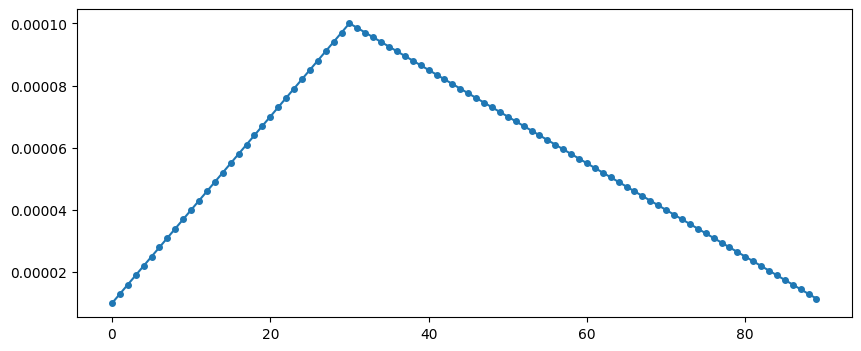

In [44]:
def lr_num(
    epoch,
    n_warmup_epochs=30,
    n_epochs=90,
    base_lr=1e-4,
    warmup_lr_start=1e-5,
    end_lr=1e-5,
):
    if epoch <= n_warmup_epochs:
        # Linear warmup phase
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / n_warmup_epochs)
    else:
        # Linear decay phase
        total_decay_epochs = n_epochs - n_warmup_epochs
        decay_epoch = epoch - n_warmup_epochs
        lr = base_lr - (base_lr - end_lr) * (decay_epoch / total_decay_epochs)
    return lr


x = list(range(90))
lr_out = [lr_num(i) for i in x]
plt.figure(figsize=(10, 4))
plt.plot(x, lr_out, marker="o", linestyle="-", markersize=4)
plt.show()

In [42]:
def train_mevis(
    args,
    net: torch.nn.Module,
    optimizer,
    loss_func,
    dataset,
    epoch,
    writer,
):
    epoch_loss = 0
    # train mode
    net.train()
    optimizer.zero_grad()

    with tqdm(total=len(dataset), desc=f"Epoch {epoch}", unit="batch") as pbar:
        for i in range(len(dataset)):
            pack = dataset[i]
            imgs = pack["images"]
            masks = pack["masks"]
            attens = pack["atten_map"]
            # Send prompt with the probablity of *args.prompt_probability*, else None
            if torch.bernoulli(torch.tensor([args.prompt_probability])).bool().item():
                if "pt" not in pack:
                    imgs, pt, masks = generate_click_prompt(imgs, masks)
                    point_labels = torch.ones(imgs.size(0))
                else:
                    pt = pack["pt"]
                    point_labels = pack["p_label"]

                if point_labels[0] != -1:
                    point_coords = pt
                    coords_torch = torch.as_tensor(
                        point_coords, dtype=torch.float, device=DEVICE
                    )
                    labels_torch = torch.as_tensor(
                        point_labels, dtype=torch.int, device=DEVICE
                    )
                    coords_torch, labels_torch = (
                        coords_torch[None, :, :],
                        labels_torch[None, :],
                    )
                    pt = (coords_torch, labels_torch)

            else:
                pt = None

            """Train"""
            with torch.no_grad():
                imge = net.image_encoder(imgs)
                se, de = net.prompt_encoder(
                    points=pt,
                    boxes=None,
                    masks=None,
                )
                pe = torch.stack(
                    [net.prompt_encoder.get_dense_pe() for _ in range(imge.shape[0])],
                    dim=0,
                ).squeeze(1)
                imge = net.attention_fusion(imge, attens.unsqueeze(1))
            pred, _ = net.mask_decoder(
                image_embeddings=imge,
                image_pe=pe,
                sparse_prompt_embeddings=se,
                dense_prompt_embeddings=de,
                multimask_output=True,
            )

            loss = loss_func(pred[:, 1:2, :, :], masks)
            pbar.set_postfix(**{"loss (batch)": loss.item()})
            writer.add_scalar(
                "Batch Loss/Training", loss.item(), epoch * len(dataset) + i
            )
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            pbar.update()

    return loss


def validate_mevis(
    args,
    net: torch.nn.Module,
    loss_func,
    dataset,
    epoch,
    writer,
):
    net.eval()
    sum_loss = 0
    thresholds = (0.0, 0.25, 0.5, 0.7, 0.9)
    result_dict = {str(key): {"iou_class": 0, "dice_class": 0} for key in thresholds}
    n_val = len(dataset)

    with tqdm(total=n_val, desc="Validation round", unit="batch", leave=True) as pbar:
        for i in range(n_val):
            pack = dataset[i]
            imgsw = pack["images"]
            masksw = pack["masks"]
            attensw = pack["atten_map"]
            
            # Send prompt with the probablity of *args.prompt_probability*, else None
            if torch.bernoulli(torch.tensor([args.prompt_probability])).bool().item():
                if "pt" not in pack:
                    imgsw, ptw, masksw = generate_click_prompt(imgsw, masksw)
                else:
                    ptw = pack["pt"]
                    point_labels = pack["p_label"]
            else:
                ptw = None

            buoy = 0
            if args.evl_chunk:
                evl_ch = int(args.evl_chunk)
            else:
                evl_ch = int(imgsw.size(0))

            while (buoy + evl_ch) <= imgsw.size(0):
                pt = ptw
                imgs = imgsw[buoy : buoy + evl_ch]
                masks = masksw[buoy : buoy + evl_ch]
                attens = attensw[buoy : buoy + evl_ch]
                buoy += evl_ch

                point_labels = torch.ones(imgs.size(0))

                if point_labels[0] != -1 and pt != None:
                    point_coords = pt
                    coords_torch = torch.as_tensor(
                        point_coords, dtype=torch.float, device=DEVICE
                    )
                    labels_torch = torch.as_tensor(
                        point_labels, dtype=torch.int, device=DEVICE
                    )
                    coords_torch, labels_torch = (
                        coords_torch[None, :, :],
                        labels_torch[None, :],
                    )
                    pt = (coords_torch, labels_torch)

                """test"""
                with torch.no_grad():
                    imge = net.image_encoder(imgs)

                    se, de = net.prompt_encoder(
                        points=pt,
                        boxes=None,
                        masks=None,
                    )
                    pe = torch.stack(
                        [
                            net.prompt_encoder.get_dense_pe()
                            for _ in range(imge.shape[0])
                        ],
                        dim=0,
                    ).squeeze(1)
                    imge = net.attention_fusion(imge, attens.unsqueeze(1))
                    pred, _ = net.mask_decoder(
                        image_embeddings=imge,
                        image_pe=pe,
                        sparse_prompt_embeddings=se,
                        dense_prompt_embeddings=de,
                        multimask_output=True,
                    )

                    loss = loss_func(pred[:, 1:, :, :], masks)
                    pbar.set_postfix(**{"loss (batch)": loss.item()})
                    # writer.add_scalar(
                    #     "Batch Loss/validation", loss.item(), epoch * len(dataset) + i
                    # )
                    sum_loss += loss
                    temp = eval_seg(pred[:, 1:, :, :], masks, thresholds)
                    for th in result_dict.keys():
                        for met, val in result_dict[th].items():
                            result_dict[th][met] = val + temp[th].get(met, 0)

            pbar.update()

    if args.evl_chunk:
        n_val = n_val * (imgsw.size(0) // evl_ch)
    for th in result_dict.keys():
        result_dict[th] = {k: val / n_val for k, val in result_dict[th].items()}

    return sum_loss / n_val, result_dict

In [24]:
DATASET_BATCH_SIZE = 20

dataset_test = MRI_dataset_batched(
    args,
    data_file=TEST_DATA_FILE,
    batch_size=DATASET_BATCH_SIZE,
    phase="test",
    operation_mode="queue",
    mask_out_size=args.out_size,
    attention_size=64,
    channel_num=1,
    crop=False,
    crop_size=1024,
    targets=["all"],
    cls=1,
    if_prompt=True,
    prompt_type="point",
    region_type="largest_15",
    prompt_num=15,
    if_attention_map=True,
    device="cpu",#DEVICE,
)

dataset_train = MRI_dataset_batched(
    args,
    data_file=TRAIN_DATA_FILE,
    batch_size=DATASET_BATCH_SIZE,
    phase="train",
    operation_mode="queue",
    mask_out_size=args.out_size,
    attention_size=64,
    channel_num=1,
    crop=False,
    crop_size=1024,
    targets=["all"],
    cls=1,
    if_prompt=True,
    prompt_type="point",
    region_type="largest_15",
    prompt_num=15,
    if_attention_map=True,
    device=DEVICE,
)

In [8]:
# torch.backends.cudnn.benchmark = True
BASE_LEARNING_RATE = 5e-4
WARMUP_LR_START = 1E-5
lossfunc = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
optimizer = torch.optim.AdamW(sam_mevis.parameters(), lr=BASE_LEARNING_RATE)

In [12]:
EPOCHS = 40
WARMUP_EPOCHS = 20
valid_every = 2
save_every = 3
train_folder = "decoder_only/resampled"
base_save = CHECKPOINT_DIRECTORY / train_folder
base_save.mkdir(exist_ok=True)
log_save = LOGDIR / train_folder
log_save.mkdir(parents=True, exist_ok=True)
if "bone_sam" in sam_checkpoint:
    start_time = datetime.now().strftime(r"%Y-%m-%d %H:%M:%S")
    epoch = 0
else:
    start_time = sam_checkpoint.split("/")[1]
    epoch = int(sam_checkpoint.split("epoch")[1].split("-")[0])
writer = SummaryWriter(log_dir=log_save / start_time)

epoch = 0
pytorch_total_params = sum(p.numel() for p in sam_mevis.parameters() if p.requires_grad)
print("Number of trainable parameters:", pytorch_total_params)


Number of trainable parameters: 132352


In [16]:
sam_mevis.mask_decoder.transformer.layers[1].Adapter.D_fc1

Linear(in_features=256, out_features=64, bias=True)

In [13]:
while epoch < (WARMUP_EPOCHS + EPOCHS):
    optimizer = lr_scheduler(
        optimizer,
        epoch,
        warmup_epochs=WARMUP_EPOCHS,
        base_lr=BASE_LEARNING_RATE,
        warmup_lr_start=WARMUP_LR_START,
    )
    dataset_train.on_epoch_end()
    loss = train_mevis(
        args,
        net=sam_mevis,
        optimizer=optimizer,
        loss_func=lossfunc,
        dataset=dataset_train,
        epoch=epoch,
        writer=writer,
    )
    writer.add_scalars("DiceCEloss", {"training": loss}, epoch)
    write_hists(sam_mevis, writer=writer, epoch=epoch)
    if epoch % valid_every == 0:
        val_loss, val_result = validate_mevis(
            args,
            net=sam_mevis,
            loss_func=lossfunc,
            dataset=dataset_test,
            epoch=epoch,
            writer=writer,
        )
        writer.add_scalars("DiceCEloss", {"validation": val_loss}, epoch)
        for key, value in val_result.items():
            for key_in, value_in in value.items():
                writer.add_scalar(f"Validation Metrics/{key_in}/thr{key}", value_in, epoch)
    if epoch % save_every == 0:
        save_path = base_save / f"mevis_sam-epoch{epoch}.pth"
        torch.save(sam_mevis.state_dict(), save_path)
        print(
            f"saved model at {str(save_path)}"
        )

    epoch += 1

Epoch 0:   0%|          | 0/250 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/66 [00:00<?, ?batch/s]

saved model at /data/sab_data/checkpoints/decoder_only/mevis_sam-epoch0.pth


Epoch 1:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 2:   0%|          | 0/250 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/66 [00:00<?, ?batch/s]

Epoch 3:   0%|          | 0/250 [00:00<?, ?batch/s]

saved model at /data/sab_data/checkpoints/decoder_only/mevis_sam-epoch3.pth


Epoch 4:   0%|          | 0/250 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/66 [00:00<?, ?batch/s]

Epoch 5:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 6:   0%|          | 0/250 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/66 [00:00<?, ?batch/s]

saved model at /data/sab_data/checkpoints/decoder_only/mevis_sam-epoch6.pth


Epoch 7:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 8:   0%|          | 0/250 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/66 [00:00<?, ?batch/s]

Epoch 9:   0%|          | 0/250 [00:00<?, ?batch/s]

saved model at /data/sab_data/checkpoints/decoder_only/mevis_sam-epoch9.pth


Epoch 10:   0%|          | 0/250 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/66 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [19]:
write_hists(sam_mevis, writer=writer, epoch=1)

In [23]:
val_loss, val_result = validate_mevis(
            args,
            net=sam_mevis,
            loss_func=lossfunc,
            dataset=dataset_test,
            epoch=1,
            writer=writer,
        )

Validation round:   0%|          | 0/66 [00:00<?, ?batch/s]

In [25]:
for key, value in val_result.items():
    for key_in, value_in in value.items():
        writer.add_scalar(f"IOU/{key_in}/{key}", value_in, epoch)

In [16]:
print(loss, val_loss, val_result)

tensor(0.5037, device='cuda:0') {'0.0': {'iou_back': -1.0, 'iou_class': 0.5267612152930462, 'dice_back': -1.0, 'dice_class': 0.5173862292007967}, '0.25': {'iou_back': -1.0, 'iou_class': 0.5405494137243791, 'dice_back': -1.0, 'dice_class': 0.5240659442814913}, '0.5': {'iou_back': -1.0, 'iou_class': 0.5499592344417716, 'dice_back': -1.0, 'dice_class': 0.5281071554530751}, '0.7': {'iou_back': -1.0, 'iou_class': 0.5536853079542969, 'dice_back': -1.0, 'dice_class': 0.5287035708174561}, '0.9': {'iou_back': -1.0, 'iou_class': 0.5542145951679258, 'dice_back': -1.0, 'dice_class': 0.5272461731325496}}


for base model on test set:

    iou               0.5267612152930462
    dice_score        0.5173862292007967
\
decoder_only/2024-08-10 19:26:43/mevis_sam-epoch80-final.pth model on test set:

    pixel_accuracy    0.985118
    iou                0.60849
    dice_score        0.617276
    DiceCELoss        1.539488
\
decoder_only/2024-08-10 19:26:43/mevis_sam-epoch60-final.pth model on test set:

    pixel_accuracy    0.985452
    iou               0.606201
    dice_score        0.620731
    DiceCELoss        1.539338
\

decoder_only/resampled/2024-08-12 10:30:07/mevis_sam-epoch60.pth model on test set:

    pixel_accuracy    0.983529
    iou               0.633876
    dice_score        0.656472
    DiceCELoss        1.519845


### Layers to train:
* Image encoder:
    + patch_embed
    + layers.1.blocks.0.MLP_Adapter
    + layers.1.blocks.0.Space_Adapter
    + layers.1.blocks.1.MLP_Adapter
    + layers.1.blocks.1.Space_Adapter
    + layers.2.blocks.0.MLP_Adapter
    + layers.2.blocks.0.Space_Adapter
    + layers.2.blocks.1.MLP_Adapter
    + layers.2.blocks.1.Space_Adapter
* Mask decoder:
    + transformer.layers.0.MLP_Adapter
    + transformer.layers.0.Adapter
    + transformer.layers.1.MLP_Adapter
    + transformer.layers.1.Adapter

In [ ]:
def get_unique_layer_names(model):
    unique_layer_names = set()
    for module in model.modules():
        name = module.__class__.__name__
        unique_layer_names.add(name)
    return list(unique_layer_names)

adapter_layers = get_unique_layer_names(sam_mevis.mask_decoder)
adapter_layers

In [12]:
image_encoder_layers = [
    "patch_embed",
    "layers.1.blocks.0.MLP_Adapter",
    "layers.1.blocks.0.Space_Adapter",
    "layers.1.blocks.1.MLP_Adapter",
    "layers.1.blocks.1.Space_Adapter",
    "layers.2.blocks.0.MLP_Adapter",
    "layers.2.blocks.0.Space_Adapter",
    "layers.2.blocks.1.MLP_Adapter",
    "layers.2.blocks.1.Space_Adapter",
]
mask_decoder_layers = [
    "transformer.layers.0.MLP_Adapter",
    "transformer.layers.0.Adapter",
    "transformer.layers.1.MLP_Adapter",
    "transformer.layers.1.Adapter",
]
for n, m in list(sam_mevis.image_encoder.named_modules()) + list(sam_mevis.mask_decoder.named_modules()):
    if n in image_encoder_layers:
        print("Image encoder:", n)
        print(m)
    if n in mask_decoder_layers:
        print("Mask decoder:", n)
        print(m)

Image encoder: patch_embed
PatchEmbed(
  (seq): Sequential(
    (0): Conv2d_BN(
      (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GELU(approximate='none')
    (2): Conv2d_BN(
      (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)
Image encoder: layers.1.blocks.0.MLP_Adapter
Adapter(
  (act): GELU(approximate='none')
  (D_fc1): Linear(in_features=128, out_features=32, bias=True)
  (D_fc2): Linear(in_features=32, out_features=128, bias=True)
)
Image encoder: layers.1.blocks.0.Space_Adapter
Adapter(
  (act): GELU(approximate='none')
  (D_fc1): Linear(in_features=128, out_features=32, bias=True)
  (D_fc2): Linear(in_features=32, out_features=128, bias=True)
)
Image encoder: layers.1.blocks.1.MLP_Adapter
Adapter(

In [19]:
def eval_model(net, dataset, loss_func):
    net.eval()
    result_dict = {}
    with tqdm(
        total=len(dataset),
        desc=f"Running inference on queued batches of size {dataset.batch_size}",
        unit="Batch",
    ) as pbar:
        for ind in range(len(dataset)):
            data = dataset[ind]
            low_res_masks, _ = do_inference_on_batch(net, data)
            low_res_masks_bool = low_res_masks > net.mask_threshold
            cat_indexes = data.get("cat_indexes", [0])
            for i in range(len(cat_indexes)):
                postfix = "" if i == 0 else str(i)
                orig_size = data[f"original_size{postfix}"]
                img_name = data[f"img_name{postfix}"]
                slices = data[f"slices{postfix}"]

                if i + 1 >= len(cat_indexes):
                    sliced_mask = data["masks"][cat_indexes[i] :]
                    sliced_prediction = low_res_masks_bool[cat_indexes[i] :]
                else:
                    sliced_mask = data["masks"][cat_indexes[i] : cat_indexes[i + 1]]
                    sliced_prediction = low_res_masks_bool[
                        cat_indexes[i] : cat_indexes[i + 1]
                    ]

                with torch.no_grad():
                    dice_score_batch = dice_coeff(
                        sliced_mask, sliced_prediction.to(torch.float32)[:, 1:2, :, :]
                    ).item()

                pixel_acc_batch = pixel_accuracy(
                    sliced_prediction[:, 1:2, :, :], sliced_mask
                )
                iou_batch = iou_torch(
                    sliced_prediction[:, 1:2, :, :], sliced_mask.clone().to(torch.int)
                )

                loss = loss_func(sliced_prediction[:, 1:2, :, :].to(torch.float32), sliced_mask)
                # temp = eval_seg(pred[:,1:, :, :], masks, thresholds)
                # print(f"temp at epoch {epoch}: {temp} len:{pred.size(0)}")
                # for th in result_dict.keys():
                #     for met, val in result_dict[th].items():
                #         result_dict[th][met] = val + temp[th][met]

                if img_name in result_dict.keys():
                    result_dict[img_name]["prediction_path"].append(f"{img_name.split(".")[0]}-{slices[0]}-{slices[-1]}")
                    result_dict[img_name]["pixel_accuracy"].append(pixel_acc_batch)
                    result_dict[img_name]["iou"].append(iou_batch)
                    result_dict[img_name]["dice_score"].append(dice_score_batch)
                    result_dict[img_name]["DiceCELoss"].append(loss.item())
                else:
                    result_dict[img_name] = {
                        "prediction_path": [f"{img_name.split(".")[0]}-{slices[0]}-{slices[-1]}"],
                        "pixel_accuracy": [pixel_acc_batch],
                        "iou": [iou_batch],
                        "dice_score": [dice_score_batch],
                        "DiceCELoss": [loss.item()],
                    }
            pbar.update(1)
    return result_dict


result_dict_eval = eval_model(sam_mevis, dataset_test, loss_func=lossfunc)

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

In [ ]:
result_dict_eval_merged = merge_metrics(result_dict_eval)

# result_dict_eval_merged
result_dict_eval

In [22]:
with open("./eval_results/decoder_only_resampled_2024-08-12 10:30:07_epoch60_model_test.json", "w") as f:
    json.dump(
        result_dict_eval_merged,
        f,
        indent=4,
        sort_keys=False,
        separators=(",", ": "),
    )

In [21]:
"""pixel_accuracy    0.985118
iou                0.60849
dice_score        0.617276
DiceCELoss        1.539488
dtype: object
"""
df = pd.DataFrame.from_dict(result_dict_eval_merged).T.drop("prediction_path", axis=1)
df.mean(axis=0)

pixel_accuracy    0.983529
iou               0.633876
dice_score        0.656472
DiceCELoss        1.519845
dtype: object

In [26]:
def sort_names(name):
    # Extract number
    match = re.search(r"(\d+)", name)
    number = int(match.group(1)) if match else float("inf")
    return number


sam_checkpoints = list(
    (CHECKPOINT_DIRECTORY / "decoder_only/resampled/2024-08-12 10:30:07/").glob("*.pth")
)
all_result_dicts = {}
for chkpnt in sam_checkpoints:
    sam_mevis.load_state_dict(
        torch.load(
            chkpnt,
            map_location=torch.device(DEVICE),
        ),
        strict=True,
    )
    sam_mevis = sam_mevis.to(DEVICE)
    result_dict_eval = eval_model(sam_mevis, dataset_test, loss_func=lossfunc)
    result_dict_eval_merged = merge_metrics(result_dict_eval)
    all_result_dicts[chkpnt.name] = result_dict_eval_merged
    
all_result_dicts = {
    k: v for k, v in sorted(all_result_dicts.items(), key=lambda x: sort_names(x[0]))
}

/tmp/ipykernel_366368/3707489999.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

Running inference on queued batches of size 40:   0%|          | 0/66 [00:00<?, ?Batch/s]

In [34]:
for chkpnt in sorted(sam_checkpoints, key=lambda x: sort_names(x.name)):
    red_dict = all_result_dicts[chkpnt.name]
    df = pd.DataFrame.from_dict(red_dict).T.drop("prediction_path", axis=1)
    print(chkpnt.name, "\n", df.mean(axis=0).to_string(), "\n")


with open(
    "./eval_results/decoder_only_resampled_2024-08-12 10:30:07_all_models_test.json",
    "w",
) as f:
    json.dump(
        all_result_dicts,
        f,
        indent=4,
        sort_keys=False,
        separators=(",", ": "),
    )

mevis_sam-epoch0.pth 
 pixel_accuracy    0.976646
iou               0.527404
dice_score        0.538444
DiceCELoss        1.527275 

mevis_sam-epoch3.pth 
 pixel_accuracy    0.982004
iou               0.615592
dice_score        0.615522
DiceCELoss        1.520586 

mevis_sam-epoch6.pth 
 pixel_accuracy    0.981213
iou               0.605275
dice_score        0.621958
DiceCELoss        1.521463 

mevis_sam-epoch9.pth 
 pixel_accuracy    0.982838
iou               0.635008
dice_score        0.648476
DiceCELoss        1.519185 

mevis_sam-epoch12.pth 
 pixel_accuracy    0.982427
iou               0.628734
dice_score        0.651373
DiceCELoss        1.519778 

mevis_sam-epoch15.pth 
 pixel_accuracy    0.982805
iou                0.64226
dice_score        0.665056
DiceCELoss        1.518501 

mevis_sam-epoch18.pth 
 pixel_accuracy    0.982585
iou               0.633171
dice_score        0.660878
DiceCELoss        1.519621 

mevis_sam-epoch21.pth 
 pixel_accuracy    0.983008
iou            

In [9]:
LOGDIR.mkdir(parents=True, exist_ok=True)
writer = SummaryWriter(LOGDIR/"learning")

In [28]:
def forward(images, masks=None, atten_map=None, prompt=False):
    bs = images.shape[0]
    device = images.device
    atten_map = torch.zeros((bs, 1, 64, 64), device=device) if atten_map == None else atten_map 
    
    with torch.no_grad():
        image_embeddings = sam_mevis.image_encoder(images)
        if prompt and masks != None:
            images, point_coords, masks = generate_click_prompt(images, masks)
            point_labels = torch.ones(images.size(0), device=device)
            coords_torch = torch.as_tensor(
                point_coords, dtype=torch.float, device=device
            )
            labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=device)
            coords_torch, labels_torch = (
                coords_torch[None, :, :],
                labels_torch[None, :],
            )
            pt = (coords_torch, labels_torch)
        else:
            pt = None
        sparse_embeddings, dense_embeddings = sam_mevis.prompt_encoder(
            points=pt, boxes=None, masks=None
        )

        image_pe = torch.stack(
            [sam_mevis.prompt_encoder.get_dense_pe() for i in range(bs)], dim=0
        ).squeeze(1)
        image_embeddings = sam_mevis.attention_fusion(image_embeddings, atten_map)
        low_res_masks, iou_predictions = sam_mevis.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=image_pe,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
        )
    return low_res_masks, iou_predictions

sam_mevis.forward = forward

In [29]:
writer.add_graph(model=sam_mevis, input_to_model=dataset_test[2]["images"])

/home/ubuntu/Thesis_code/models/sam/modeling/tiny_vit_sam.py:347: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert L == H * W, "input feature has wrong size"
/home/ubuntu/Thesis_code/models/sam/modeling/tiny_vit_sam.py:137: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  B = len(x)
/home/ubuntu/Thesis_code/models/sam/modeling/mask_decoder.py:216: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to 

In [12]:
# try to make training loop
def m_decoder_input_maker(batch, sam):
    bs = batch["images"].shape[0]
    image_embeddings = sam.image_encoder(batch["images"])
    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
        points=None, boxes=None, masks=None
    )
    sparse_embeddings = sparse_embeddings.squeeze(0)
    dense_embeddings = dense_embeddings.squeeze(0)

    image_pe = torch.stack(
        [sam.prompt_encoder.get_dense_pe() for i in range(bs)], dim=0
    ).squeeze(1)
    for i in range(image_embeddings.shape[0]):
        image_embeddings[i] = sam.attention_fusion(
            image_embeddings[i : i + 1], batch["atten_map"][i : i + 1]
        )
    # low_res_masks, iou_predictions = sam.mask_decoder(
    #     image_embeddings=image_embeddings,
    #     image_pe=image_pe,
    #     sparse_prompt_embeddings=sparse_embeddings,
    #     dense_prompt_embeddings=dense_embeddings,
    #     multimask_output=True,
    # )

    # low_res_masks_bool = low_res_masks > sam_fine_tune.mask_threshold
    
    return {
        "image_embeddings": image_embeddings,
        "sparse_prompt_embeddings": sparse_embeddings,
        "dense_prompt_embeddings": dense_embeddings,
        "image_pe": image_pe,
        "multimask_output": torch.tensor(True, dtype=torch.bool, device=DEVICE),
    }

m_decoder_input = m_decoder_input_maker(mris_batched[2], sam_mevis).values()

writer.add_graph(
    model=sam_mevis.mask_decoder,
    input_to_model=m_decoder_input,
)

mask decoder 0 torch.Size([4, 256]) torch.Size([256, 64, 64])
mask decoder 1 torch.Size([256, 4, 256]) torch.Size([256, 64, 64])
Sizes of tensors must match except in dimension 1. Expected size 256 but got size 64 for tensor number 1 in the list.
Error occurs, No graph saved


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 256 but got size 64 for tensor number 1 in the list.

In [7]:
sam_mevis.train()
for param in sam_mevis.parameters():
    param.requires_grad = False
for name, param in sam_mevis.image_encoder.named_parameters():
    if name in image_encoder_layers:
        param.requires_grad = True
for name, param in sam_mevis.mask_decoder.named_parameters():
    if name in mask_decoder_layers:
        param.requires_grad = True

TypeError: 'type' object is not iterable

python\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader\nfrom torch.utils.tensorboard import SummaryWriter\n\ndef train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, writer):\n    for epoch in range(num_epochs):\n        model.train()\n        running_loss = 0.0\n        for i, (inputs, labels) in enumerate(train_loader):\n            optimizer.zero_grad()\n            outputs = model(inputs)\n            loss = criterion(outputs, labels)\n            loss.backward()\n            optimizer.step()\n            running_loss += loss.item()\n\n            # Log training loss every 100 batches\n            if i % 100 == 99:\n                writer.add_scalar('Training Loss', running_loss / 100, epoch * len(train_loader) + i)\n                running_loss = 0.0\n\n        validate_model(model, val_loader, criterion, writer, epoch)\n\ndef validate_model(model, val_loader, criterion, writer, epoch):\n    model.eval()\n    val_loss = 0.0\n    correct = 0\n    total = 0\n    with torch.no_grad():\n        for inputs, labels in val_loader:\n            outputs = model(inputs)\n            loss = criterion(outputs, labels)\n            val_loss += loss.item()\n            _, predicted = torch.max(outputs.data, 1)\n            total += labels.size(0)\n            correct += (predicted == labels).sum().item()\n\n    avg_val_loss = val_loss / len(val_loader)\n    accuracy = 100 * correct / total\n    writer.add_scalar('Validation Loss', avg_val_loss, epoch)\n    writer.add_scalar('Validation Accuracy', accuracy, epoch)\n\n    print(f\"Validation Loss: {avg_val_loss}, Accuracy: {accuracy}%\")\n\n# Example usage\nif __name__ == \"__main__\":\n    model = ...  # Your model here\n    train_dataset = ...  # Your training dataset here\n    val_dataset = ...  # Your validation dataset here\n\n    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\n    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)\n\n    criterion = nn.CrossEntropyLoss()\n    optimizer = optim.Adam(model.parameters(), lr=0.001)\n    num_epochs = 10\n\n    # Initialize TensorBoard writer\n    writer = SummaryWriter('runs/experiment_1')\n\n    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, writer)\n\n    # Close the writer\n    writer.close()\n